In [3]:
import sys
sys.path.append('/home/ingo/src/ros_ws/src/tracetools/src/tracing/')
import trace_pandas as tp
import pandas as pd
import numpy as np
from ros_mapping import map_roscpp
from pandas.tseries.offsets import Milli, Second


%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')

In [12]:
basic_model=[
    ("local_costmap/obstacle_layer", "receipt_time"),
    ("local_costmap/obstacle_layer", "timestamp"),
    ("costs local_costmap/obstacle_layer", "timestamp"),
    ("local planner", "timestamp"),
    ("/navigation_velocity_smoother/raw_cmd_vel", "timestamp")
]
unsynced_model=[
    ("local_costmap/obstacle_layer", "receipt_time"),
    ("after tf scan local_costmap/obstacle_layer", "timestamp"),
    ("trigger update local_costmap", "timestamp"),
    ("local planner", "timestamp"),
    ("/navigation_velocity_smoother/raw_cmd_vel", "timestamp")
]

ext_model=[
    ("local_costmap/obstacle_layer", "receipt_time"),
    ("before tf scan local_costmap/obstacle_layer", "timestamp"),
    ("after tf scan local_costmap/obstacle_layer", "timestamp"),
    ("sensor sync", "timestamp"),
    ("trigger update local_costmap", "timestamp"),
    ("local planner", "timestamp"),
    ("/navigation_velocity_smoother/raw_cmd_vel", "timestamp")
]

def model_delays(trace_df, model, search_window=50):
    # extract data from input message traces
    elements=[]
    columns=[]
    have_names = False
    
    for message_name, attribute in model:
        es=trace_df.mtrace.query("message_name=='%s'" % message_name)[attribute]
        if(len(es) == 0):
            print("Warning: Could not find messages for %s" % message_name)
        elements.append(es)

    # compute delays between element entries and their respective successors from the next element
    timestamps=[]
    all_delays=[[] for i in range(1, len(elements))]
    afteriter = elements[0].iteritems()
    afteriter.__next__()
    for current, ne in zip(elements[0].iteritems(), afteriter):
        time, e = current
        _, time_next = ne
        timestamps.append(time)
        ts=e # initially should be receive time or equivalent
        name = "message stamp"
        for index, element in enumerate(elements[1:]):
            current_name = "%s-%s" % model[index+1]
            if not have_names:
                columns.append("%s -> %s" % (name, current_name))
                name = current_name
            subset=elements[index+1][ts:ts+Milli(300)]
            # see if we found something
            if len(subset) > 0 and subset[0] < time_next:
                delay=subset[0] - ts
                ts=subset[0]
            else:
                delay = pd.Timedelta(0)

            all_delays[index].append(delay)
        
        have_names = True

    df = pd.DataFrame({columns[i]: pd.Series(all_delays[i], index=timestamps) 
                        for i, e in enumerate(model[1:])}, 
                       columns=columns)
    # convert delays into milliseconds
    df/=1e6
    return df

def plot_delays(times,fname=None, **kwargs):
    times.astype(np.int64).plot.area(stacked=True, **kwargs)
    if fname is not None:
        matplotlib.pyplot.savefig(fname)

def plot_box(t, xlim=(0, 200), fname=None):
    ax=t.astype(np.int64).boxplot(vert=False, return_type='axes', showfliers=False)
    _=ax.set_xlim(xlim[0], xlim[1])
    if fname is not None:
        matplotlib.pyplot.savefig(fname)
    

In [17]:
trace2=tp.pickle2pd("/home/ingo/Data/2016/04/auto-20160425-105521.pickle", map_roscpp)

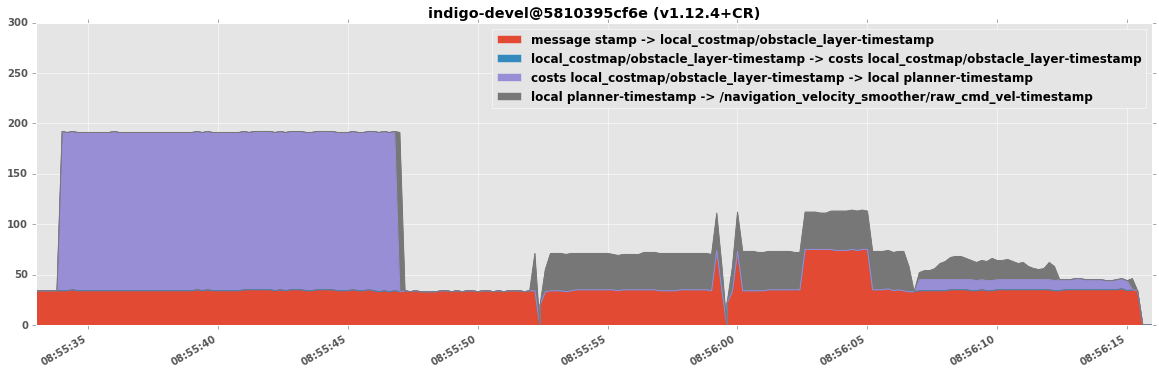

In [47]:
t=model_delays(trace2, model=basic_model)
plot_delays(t, figsize=(20, 6), ylim=(0, 300), title="indigo-devel@5810395cf6e (v1.12.4+CR)")


In [51]:
t.astype(np.int64).describe()

,message stamp -> local_costmap/obstacle_layer-timestamp,local_costmap/obstacle_layer-timestamp -> costs local_costmap/obstacle_layer-timestamp,costs local_costmap/obstacle_layer-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
count,217.000000,217,217.000000,217.000000
mean,36.350230,0,48.981567,14.714286
std,11.491016,0,70.963081,19.319953
min,0.000000,0,0.000000,0.000000
25%,34.000000,0,0.000000,0.000000
50%,34.000000,0,0.000000,0.000000
75%,35.000000,0,157.000000,36.000000
max,75.000000,0,158.000000,158.000000


In [5]:
df_upstream_5=tp.pickle2pd("/home/ingo/Temp/ita-default-22423-20160622-135450.pickle", map_roscpp)

In [6]:
df_synced_5=tp.pickle2pd("/home/ingo/Temp/ita-local_costmap_no_update-24109-20160622-143249.pickle", map_roscpp)

In [7]:
df_async_125=tp.pickle2pd("/home/ingo/Temp/ita-ita-Async-at-sensor-rate-18186-20160622-144924.pickle", map_roscpp)

In [9]:
#set(df_upstream_5.mtrace['message_name'])
t=model_delays(df_upstream_5, unsynced_model)
t_s=model_delays(df_synced_5, unsynced_model)

In [10]:
t_125=model_delays(df_async_125, unsynced_model)
t_125.astype(np.int64).describe()

,message stamp -> after tf scan local_costmap/obstacle_layer-timestamp,after tf scan local_costmap/obstacle_layer-timestamp -> trigger update local_costmap-timestamp,trigger update local_costmap-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
count,1149.000000,1149.000000,1149.000000,1149.000000
mean,3.967798,10.844212,32.123586,5.982594
std,0.384600,26.494413,21.195959,9.017678
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,42.000000,5.000000
75%,4.000000,0.000000,51.000000,5.000000
max,6.000000,76.000000,52.000000,52.000000


In [25]:
t.astype(np.int64).describe()

,message stamp -> after tf scan local_costmap/obstacle_layer-timestamp,after tf scan local_costmap/obstacle_layer-timestamp -> trigger update local_costmap-timestamp,trigger update local_costmap-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
count,1824.000000,1824.000000,1824.000000,1824.000000
mean,4.334430,45.725329,30.297149,4.484649
std,1.067651,28.389457,29.399316,3.410607
min,2.000000,0.000000,0.000000,0.000000
25%,4.000000,34.000000,5.000000,5.000000
50%,4.000000,41.000000,18.000000,5.000000
75%,5.000000,74.000000,59.000000,5.000000
max,7.000000,114.000000,187.000000,87.000000


In [26]:
t_s.astype(np.int64).describe()

,message stamp -> after tf scan local_costmap/obstacle_layer-timestamp,after tf scan local_costmap/obstacle_layer-timestamp -> trigger update local_costmap-timestamp,trigger update local_costmap-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
count,4382.000000,4382.000000,4382.000000,4382.000000
mean,4.002054,0.168873,0.509356,4.168416
std,0.445368,2.512831,0.509915,1.779933
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,4.000000
50%,4.000000,0.000000,1.000000,5.000000
75%,4.000000,0.000000,1.000000,5.000000
max,6.000000,66.000000,4.000000,18.000000


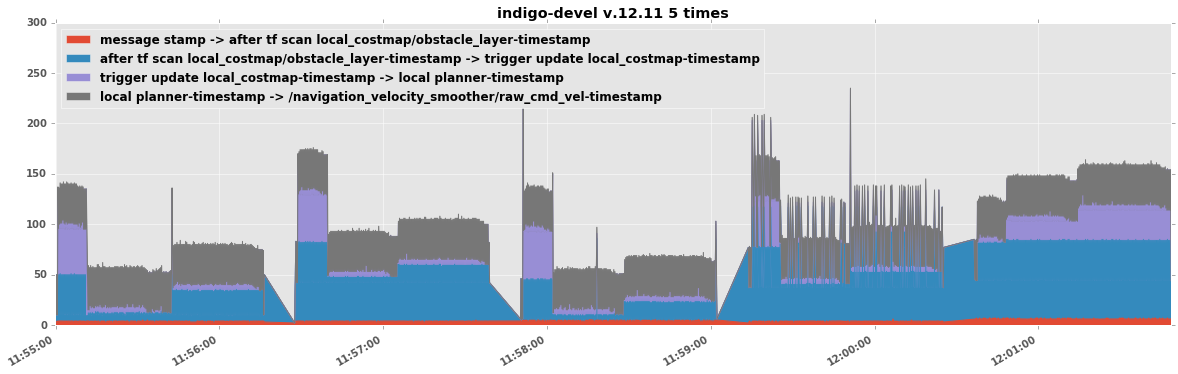

In [14]:
plot_delays(t, fname="move_base-stock.png", figsize=(20, 6), ylim=(0, 300), title="indigo-devel v.12.11 5 times")

In [11]:
matplotlib.pyplot.savefig("move_base-1.12.11, stock.png")

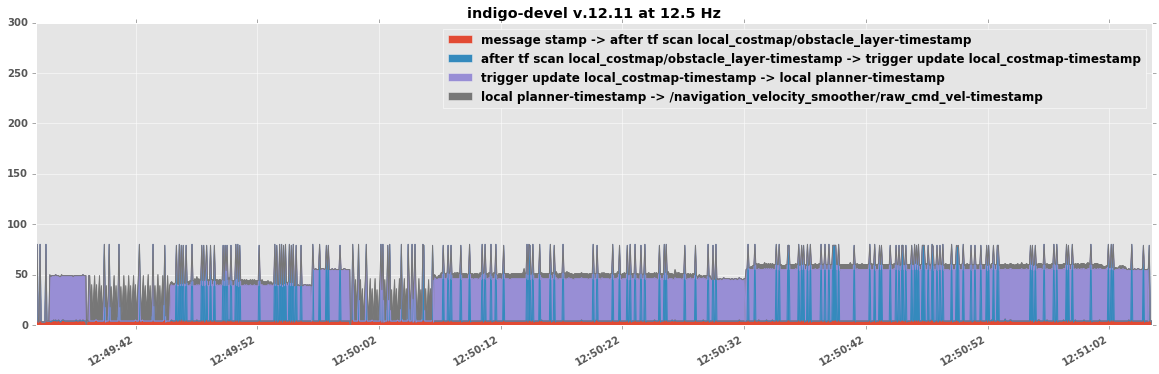

In [16]:
plot_delays(t_125, fname="move_base-1.12.11@12.5Hz.svg", figsize=(20, 6), ylim=(0, 300), title="indigo-devel v.12.11 at 12.5 Hz")

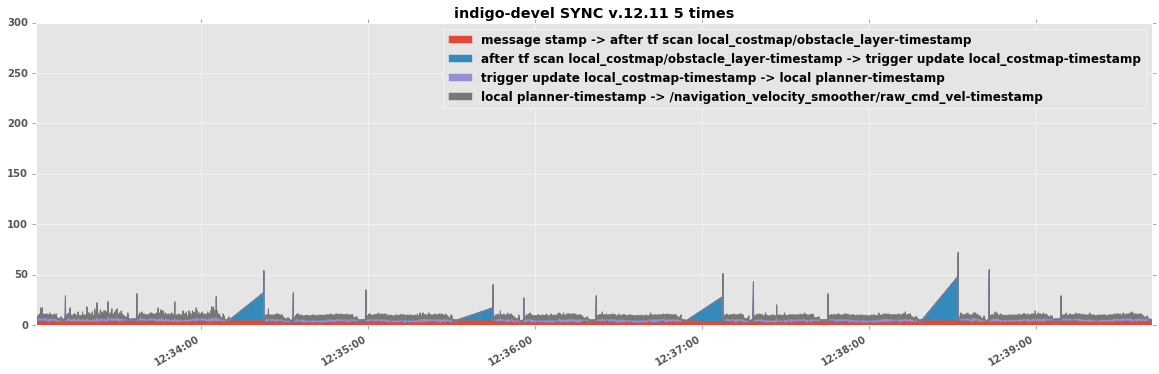

In [19]:
plot_delays(t_s, fname="rose-move_base.svg", figsize=(20, 6), ylim=(0, 300), title="indigo-devel SYNC v.12.11 5 times")

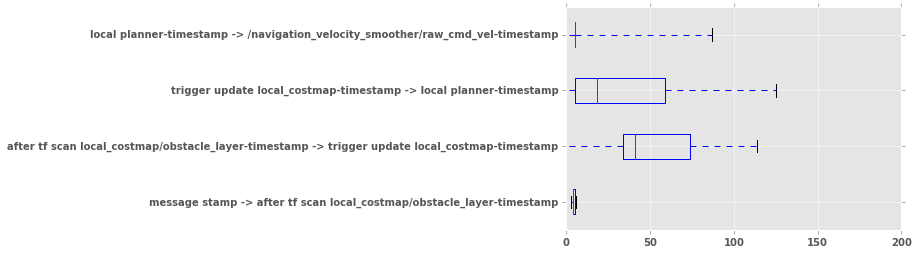

In [15]:
plot_box(t, fname="move_base-stock-boxes.svg")

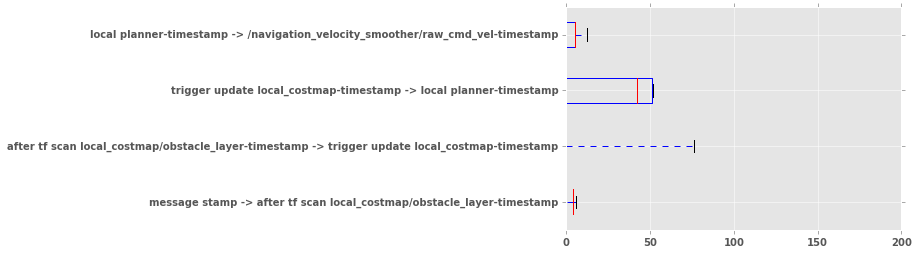

In [47]:
ax=t_125.astype(np.int64).boxplot(vert=False, return_type='axes', showfliers=False)
_=ax.set_xlim(0, 200)

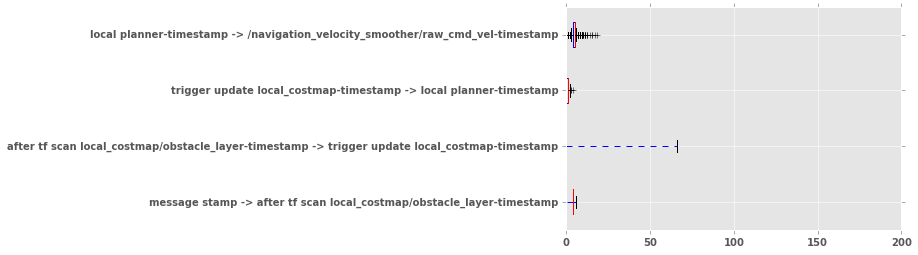

In [50]:
ax=t_s.astype(np.int64).boxplot(vert=False, return_type='axes')
_=ax.set_xlim(0, 200)

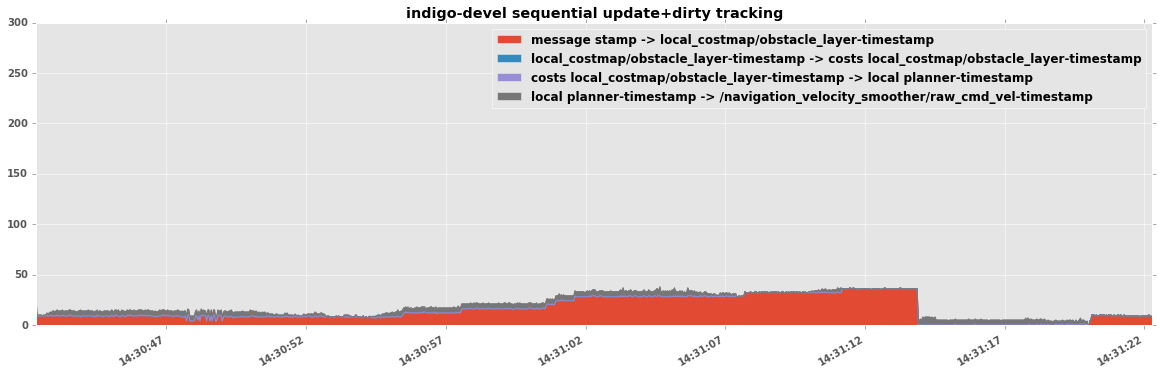

In [52]:
t=model_delays(df_synced, model=basic_model)
plot_delays(t, figsize=(20, 6), ylim=(0, 300), title="indigo-devel sequential update+dirty tracking")

In [53]:
t.astype(np.int64).describe()

,message stamp -> local_costmap/obstacle_layer-timestamp,local_costmap/obstacle_layer-timestamp -> costs local_costmap/obstacle_layer-timestamp,costs local_costmap/obstacle_layer-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
count,1000.00000,1000,1000,1000.000000
mean,15.34100,0,0,3.506000
std,11.68543,0,0,2.209716
min,0.00000,0,0,0.000000
25%,8.00000,0,0,1.000000
50%,10.00000,0,0,5.000000
75%,28.00000,0,0,5.000000
max,37.00000,0,0,9.000000


In [49]:
t.head()

,message stamp -> after tf scan local_costmap/obstacle_layer-timestamp,after tf scan local_costmap/obstacle_layer-timestamp -> trigger update local_costmap-timestamp,trigger update local_costmap-timestamp -> local planner-timestamp,local planner-timestamp -> /navigation_velocity_smoother/raw_cmd_vel-timestamp
2016-06-22 11:54:59.821289317,00:00:00.000000,00:00:00.000000,0 days,0 days
2016-06-22 11:55:00.021362595,00:00:00.000000,00:00:00.000000,0 days,0 days
2016-06-22 11:55:00.221203718,00:00:00.000000,00:00:00.000000,0 days,0 days
2016-06-22 11:55:00.421223034,00:00:00.000000,00:00:00.000000,0 days,0 days
2016-06-22 11:55:00.621258915,00:00:00.000000,00:00:00.000000,0 days,0 days


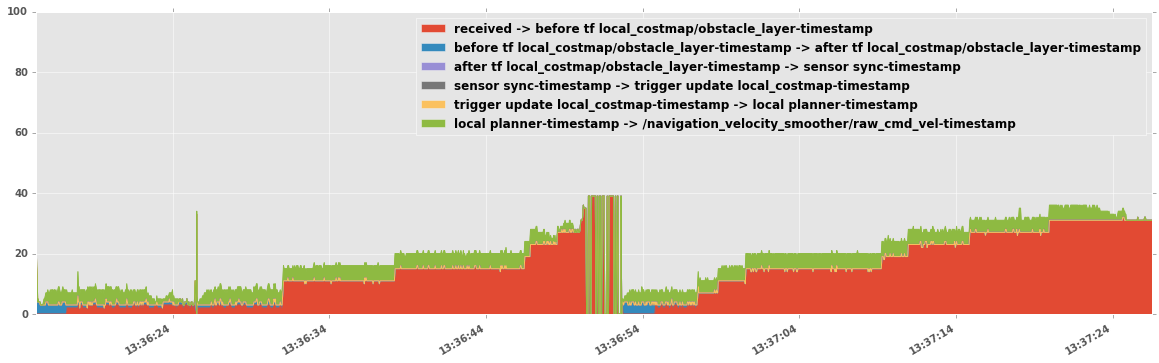

In [170]:
with_tf_model=[
    ("local_costmap/obstacle_layer", "receipt_time"),
    ("before tf local_costmap/obstacle_layer", "timestamp"),
    ("after tf local_costmap/obstacle_layer", "timestamp"),
    ("sensor sync", "timestamp"),
    ("trigger update local_costmap", "timestamp"),
    ("local planner", "timestamp"),
    ("/navigation_velocity_smoother/raw_cmd_vel", "timestamp")
]

    
df_with_tf=tp.pickle2pd("/home/ingo/Temp/turtlebot-run-14643-local_costmap_no_update-20160617-153603.pickle", map_roscpp)
time_maxage=model_delays(df_with_tf, with_tf_model)
#print(time_maxage.columns, time_maxage['execute cycle-timestamp'].max())
time_maxage/=1e6
time_maxage.astype(np.int64).plot.area(stacked=True, figsize=(20,6), ylim=(0, 100))


In [25]:
with_source_model=[
    ("local_costmap/obstacle_layer", "receipt_time"),
    ("before tf scan local_costmap/obstacle_layer", "timestamp"),
    ("after tf scan local_costmap/obstacle_layer", "timestamp"),
    ("sensor sync", "timestamp"),
    ("trigger update local_costmap", "timestamp"),
    ("local planner", "timestamp"),
    ("/navigation_velocity_smoother/raw_cmd_vel", "timestamp")
]
df=tp.pickle2pd("/home/ingo/Temp/turtlebot-run-19783-local_costmap_no_update-20160621-123535.pickle", map_roscpp)


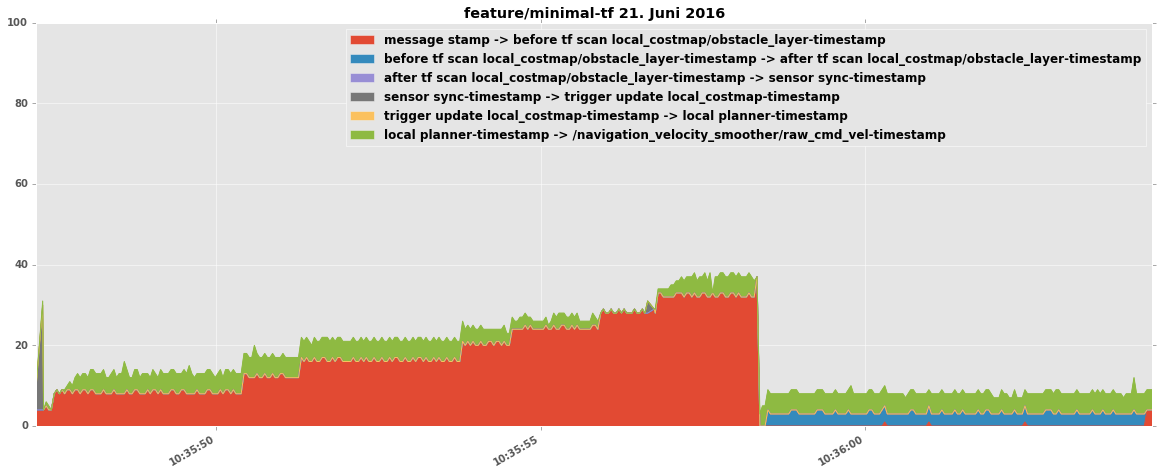

In [28]:
plot_delays(model_delays(df, with_source_model), figsize=(20,8), ylim=(0,100), title="feature/minimal-tf 21. Juni 2016")

In [46]:
plan=df.mtrace.query("message_name=='local planner'")['timestamp']
(plan - plan.shift()).describe()
sent=model_delays(df, with_source_model)['message stamp -> before tf scan local_costmap/obstacle_layer-timestamp']
sent.astype(np.int64).describe()

count    427.000000
mean      11.761124
std       11.112489
min        0.000000
25%        0.000000
50%        9.000000
75%       20.000000
max       37.000000
Name: message stamp -> before tf scan local_costmap/obstacle_layer-timestamp, dtype: float64

In [292]:
#df.invocations['duration']/=1e6
df.invocations['duration']*=1e3

In [293]:
df.invocations.query("task_id==26509").groupby("callback").agg({'duration': np.mean})\
                                                               .merge(df.functions, how='outer', left_index=True, 
                                                                      right_on='callback').sort_values(by='duration', ascending=False)

duration  callback  \
26509 12864560  0.258837  12864560   
      12864560  0.258837  12864560   
      17707136  0.257397  17707136   
      13100048  0.241163  13100048   
      13100048  0.241163  13100048   
      28362640  0.239813  28362640   
      17707184  0.052978  17707184   
      17707184  0.052978  17707184   
      17705200  0.051201  17705200   
      13100384  0.029566  13100384   
      13100384  0.029566  13100384   
      13099584  0.028050  13099584   
      17693520  0.006026  17693520   
      17693520  0.006026  17693520   
      13100320  0.005094  13100320   
      13100320  0.005094  13100320   
      17698992  0.004319  17698992   
      17698992  0.004319  17698992   
      17696512  0.003902  17696512   
      13107216  0.003781  13107216   
      13101888  0.003681  13101888   
      13101888  0.003681  13101888   
      13049328  0.003449  13049328   
      13049328  0.003449  13049328   
      17699584  0.002893  17699584   
      17699584  0.002893  17699584   
      17699040  0.002549  17699040   
      17699312  0.002236  17699312   
      13107168  0.002082  13107168   
      17705136  0.001586  17705136   
...                  ...       ...   
      28363232       NaN  28363232   
      13110496       NaN  13110496   
      13110496       NaN  13110496   
      13110704       NaN  13110704   
      13110656       NaN  13110656   
      13110656       NaN  13110656   
      17320176       NaN  17320176   
      17320176       NaN  17320176   
      17317728       NaN  17317728   
      17317728       NaN  17317728   
      17323728       NaN  17323728   
      17323600       NaN  17323600   
      17323600       NaN  17323600   
      17322464       NaN  17322464   
      17320048       NaN  17320048   
      17320048       NaN  17320048   
      17321984       NaN  17321984   
      17321936       NaN  17321936   
      17321936       NaN  17321936   
      17323872       NaN  17323872   
      13109984       NaN  13109984   
      13109984       NaN  13109984   
      17327520       NaN  17327520   
      13101408       NaN  13101408   
      13277408       NaN  13277408   
      13283008       NaN  13283008   
      13302064       NaN  13302064   
      13307424       NaN  13307424   
      17506224       NaN  17506224   
      17528160       NaN  17528160   

                                                    function_name  task_id  
26509 12864560  MinimalTFMessageFilter<LaserScan >::sensorCall...    26509  
      12864560  MinimalTFMessageFilter<LaserScan >::sensorCall...    26509  
      17707136  boost::shared_ptr<message_filters::CallbackHel...    26509  
      13100048  MinimalTFMessageFilter<LaserScan >::sensorCall...    26509  
      13100048  MinimalTFMessageFilter<LaserScan >::sensorCall...    26509  
      28362640  boost::shared_ptr<message_filters::CallbackHel...    26509  
      17707184  message_filters::Connection message_filters::S...    26509  
      17707184  boost::shared_ptr<message_filters::CallbackHel...    26509  
      17705200  boost::shared_ptr<message_filters::CallbackHel...    26509  
      13100384  boost::shared_ptr<message_filters::CallbackHel...    26509  
      13100384  message_filters::Connection message_filters::S...    26509  
      13099584  boost::shared_ptr<message_filters::CallbackHel...    26509  
      17693520  message_filters::Connection message_filters::S...    26509  
      17693520  /home/ingo/src/ros_ws/devel/lib/liblayers.so(+...    26509  
      13100320         costmap_2d::LayeredCostmap::updateCallback    26509  
      13100320  message_filters::Connection message_filters::S...    26509  
      17698992  message_filters::Connection message_filters::S...    26509  
      17698992  /home/ingo/src/ros_ws/devel/lib/liblayers.so(+...    26509  
      17696512  boost::shared_ptr<message_filters::CallbackHel...    26509  
      13107216  boost::shared_ptr<message_filters::CallbackHel...    26509  
      13101888  message_filters::Connectio

In [254]:
receipt=df.mtrace.query("message_name=='local_costmap/obstacle_layer'")['receipt_time']
receipt - receipt.shift()

2016-06-21 10:31:16.008143917               NaT
2016-06-21 10:31:16.108297235   00:00:00.079315
2016-06-21 10:31:16.127322928   00:00:00.040777
2016-06-21 10:31:16.167341385   00:00:00.039438
2016-06-21 10:31:16.207380094   00:00:00.039633
2016-06-21 10:31:16.247395624   00:00:00.040677
2016-06-21 10:31:16.287505204   00:00:00.039520
2016-06-21 10:31:16.327387047   00:00:00.039720
2016-06-21 10:31:16.367515002   00:00:00.040526
2016-06-21 10:31:16.407460173   00:00:00.039579
2016-06-21 10:31:16.447389179   00:00:00.040649
2016-06-21 10:31:16.487307307   00:00:00.039732
2016-06-21 10:31:16.527420975   00:00:00.039810
2016-06-21 10:31:16.567447202   00:00:00.040591
2016-06-21 10:31:16.607366224   00:00:00.039744
2016-06-21 10:31:16.647382770   00:00:00.039646
2016-06-21 10:31:16.687386880   00:00:00.039738
2016-06-21 10:31:16.727373716   00:00:00.040836
2016-06-21 10:31:16.767535011   00:00:00.039817
2016-06-21 10:31:16.807535814   00:00:00.039725
2016-06-21 10:31:16.847381960   00:00:00

In [7]:
t_direct=tp.pickle2pd("/home/ingo/Temp/turtlebot-run-29067-local_costmap_no_update-20160512-144411.pickle", map_roscpp)

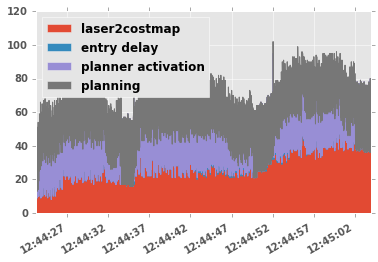

In [8]:
plot_delays2(t_direct)

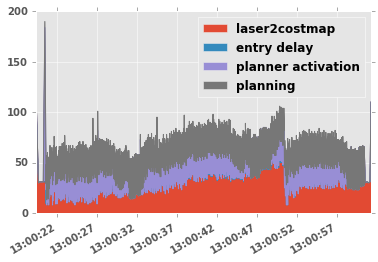

In [9]:
t_direct2=tp.pickle2pd("/home/ingo/Temp/turtlebot-run-24244-20160512-150009.pickle", map_roscpp)
plot_delays2(t_direct2)

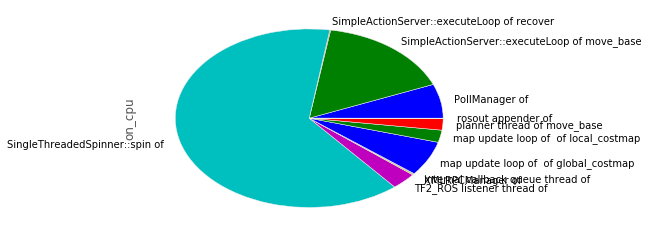

In [89]:
m=steady.merge(trace_pd.tasks)
m[m['node'] == 'move_base'].groupby("task_name").agg(np.sum)['on_cpu'].plot.pie()
matplotlib.pyplot.savefig("pie.pdf")

In [84]:
#set(trace_pd.functions.merge(trace_pd.tasks).query("node=='move_base'")['task_name'])
#trace_pd.tasks.query("node=='move_base'")
m.index = m.timestamp
r=m[m['node'] == 'move_base'].groupby("task_name").resample(Milli(100), how=np.sum)
r.index=r.index.droplevel(1)
#r['on_cpu'].plot()

function_name
actionlib::ActionServer<move_base_msgs::MoveBaseAction >::publishStatus                                                                                                                                                                                                                                                                                                                                                               Axes(0.125,0.125;0.775x0.775)
actionlib::ActionServer<move_base_msgs::ObstacleMonitorAction >::publishStatus                                                                                                                                                                                                                                                                                                                                                        Axes(0.125,0.125;0.775x0.775)
actionlib::ActionServer<move_base_msgs::RecoveryAction >::publishStatus           

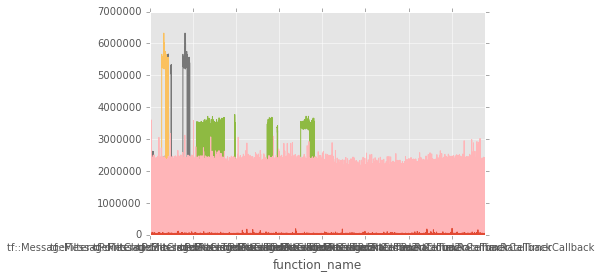

In [213]:
fns=trace_pd.invocations.merge(trace_pd.tasks).query("node=='move_base'").query("task_name=='SingleThreadedSpinner::spin of '").merge(trace_pd.functions)
fns.index=fns['function_name']
fns.groupby("function_name")["duration"].plot()

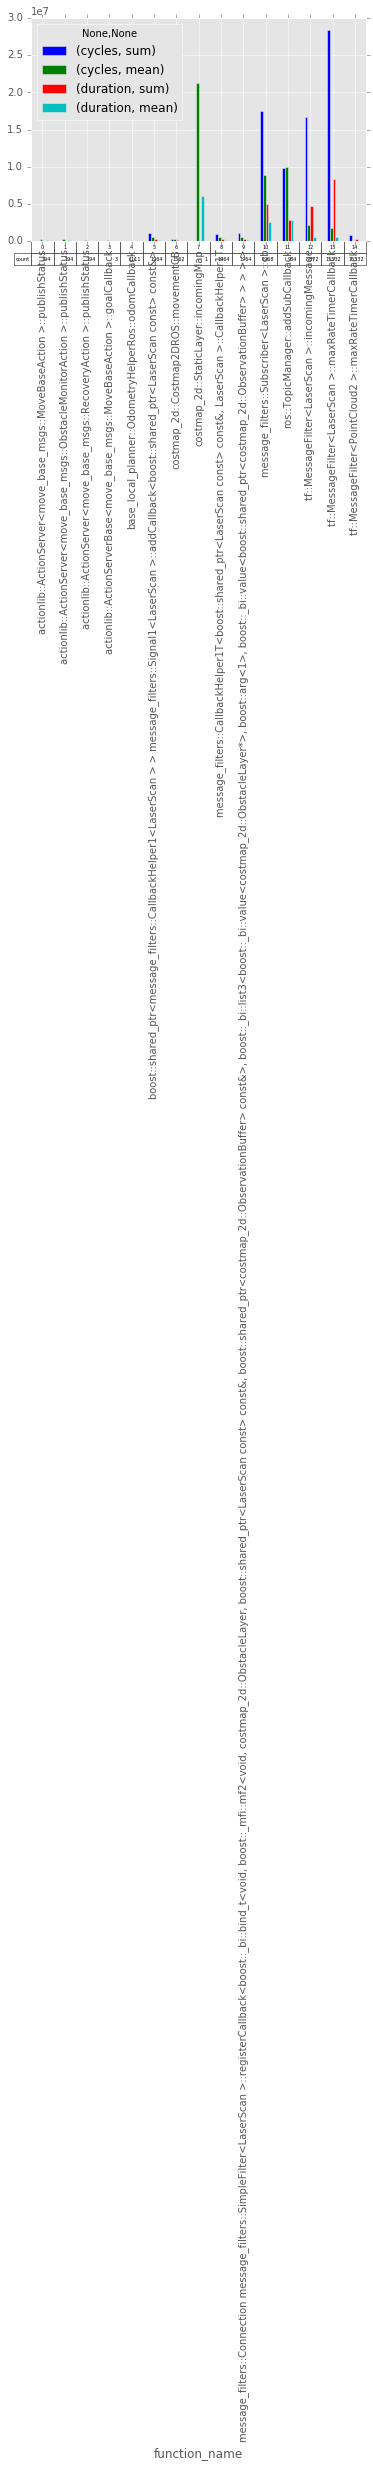

In [198]:
#trace_pd.functions.merge(trace_pd.tasks).query("node=='move_base'").query("task_name=='SingleThreadedSpinner::spin of '").merge(trace_pd.runtime).groupby("function_name").agg(np.sum)['on_cpu'].plot.bar()
#trace_pd.invocations.merge(trace_pd.tasks).query("node=='move_base'").query("task_name=='SingleThreadedSpinner::spin of '").merge(trace_pd.functions).groupby("function_name").agg(np.mean)["cycles"].plot.bar()
fns=trace_pd.invocations.merge(trace_pd.tasks).query("node=='move_base'").query("task_name=='SingleThreadedSpinner::spin of '").merge(trace_pd.functions).groupby("function_name")
means=fns.agg([np.sum, np.mean])
means[("cycles", "sum")]/=1e3
means[("duration", "sum")]/=1e3
del means['callback']
del means['task_id']
errs=fns.std()
count=fns.agg(["count"])["cycles"]
count.index=range(0, len(count))
means.plot.bar(yerr=errs, table=count.T)
#matplotlib.pyplot.savefig("table.pdf")

In [21]:
trace_pd = tp.pickle2pd("/home/ingo/Temp/auto-20160424-160146.pickle", map_roscpp)

In [75]:
#trace_pd.invocations.merge(trace_pd.functions).query("node=='move_base'")
#trace_pd.functions.merge(trace_pd.tasks, how="outer", on=['task_id', 'task_id']).query("node=='move_base'")
#set(trace_pd.functions.merge(trace_pd.tasks).query("node=='move_base'")['task_name'])
    #trace_pd.tasks.query("node=='move_base'")
#for row in trace_pd.functions:
#    print(row)
    #if "execute" in row.icol['function_name']:
    #    print(row)
for index, row in trace_pd.functions.iterrows():
    if "execute" in row['function_name']:
        #print(trace_pd.tasks[row['task_id']])
        #print(trace_pd.invocations[row['callback']])
        print(row)
#trace_pd.invocations[139887253391372]
int(0x7F3A0A0C080C)

callback                           139887253391372
function_name    move_base::MoveBase::executeCycle
task_id                                      10829
Name: (10829, 139887253391372), dtype: object


139887253391372

In [11]:
for d in trace_pd.mtrace.query("message_name=='local_costmap/obstacle_layer'")["receipt_time"][0:5]:
    print(trace_pd.)


2016-04-24 14:01:56.850618880
2016-04-24 14:01:57.050718976
2016-04-24 14:01:57.250245120
2016-04-24 14:01:57.450800128
2016-04-24 14:01:57.650768896


In [176]:
df_all=tp.pickle2pd("/home/ingo/Temp/all.pickle", map_roscpp)

In [208]:
df_all.tasks.merge(df_all.invocations).query("node=='move_base' and task_id==26816").groupby("callback").agg({'duration': np.mean}).sort_values(by="duration").merge(df_all.functions, left_index=True, right_on="callback", how="outer")

duration         callback  \
26816 36762560           1396.806738         36762560   
      32287440           1756.099470         32287440   
      47427024           2122.591914         47427024   
      36764656           2170.796690         36764656   
      36772560           2817.852246         36772560   
      36772560           2817.852246         36772560   
      32287392           3098.944085         32287392   
      32287392           3098.944085         32287392   
      47426736           3445.346631         47426736   
      47426736           3445.346631         47426736   
      36764416           3798.261229         36764416   
      36764416           3798.261229         36764416   
      32286896           3912.931136         32286896   
      32288912           5113.128311         32288912   
      32288912           5113.128311         32288912   
      36765216           5256.346092         36765216   
      36768208           7412.442049         36768208   
      36768208           7412.442049         36768208   
      32288864          26785.802237         32288864   
      32370208          28167.392584         32370208   
      32370208          28167.392584         32370208   
      36771712          52370.192080         36771712   
      36764368          53987.130024         36764368   
      36764368          53987.130024         36764368   
      32952912         347258.499730         32952912   
      32952912         347258.499730         32952912   
      139695662610128  364252.447439  139695662610128   
      139695662610128  364252.447439  139695662610128   
      36770224         383994.001617         36770224   
      36770224         383994.001617         36770224   
...                              ...              ...   
      32317664                   NaN         32317664   
      32317664                   NaN         32317664   
      47427872                   NaN         47427872   
      47427872                   NaN         47427872   
      32286176                   NaN         32286176   
      32286176                   NaN         32286176   
      32292832                   NaN         32292832   
      32292832                   NaN         32292832   
      32290912                   NaN         32290912   
      32286624                   NaN         32286624   
      32286624                   NaN         32286624   
      32291040                   NaN         32291040   
      32291040                   NaN         32291040   
      32391808                   NaN         32391808   
      32391760                   NaN         32391760   
      32391760                   NaN         32391760   
      32391984                   NaN         32391984   
      32391936                   NaN         32391936   
      32391936                   NaN         32391936   
      32289216                   NaN         32289216   
      32391856                   NaN         32391856   
      32391856                   NaN         32391856   
      32401808                   NaN         32401808   
      47444416                   NaN         47444416   
      33237936                   NaN         33237936   
      33107920                   NaN         33107920   
      33133024                   NaN         33133024   
      33149200                   NaN         33149200   
      47481728                   NaN         47481728   
      47484944                   NaN         47484944   

                                                           function_name  \
26816 36762560         boost::shared_ptr<message_filters::CallbackHel...   
      32287440         boost::shared_ptr<message_filters::CallbackHel...   
      47427024         boost::shared_ptr<message_filters::CallbackHel...   
      36764656         boost::shared_ptr<message_filters::CallbackHel...   
      36772560                costmap_2d::LayeredCostmap::updateCallback   
      36772560         message_filter